In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from kaggle_secrets import UserSecretsClient
from glob import glob
from tqdm.notebook import tqdm
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn import metrics

%matplotlib inline

2023-02-08 12:04:00.623404: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-08 12:04:00.623572: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU:', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)
GCS_DS_PATH = KaggleDatasets().get_gcs_path('website-defacement')

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
N_JOBS = cpu_count()

IMG_SIZE = 224
EPOCHS = 50

print('N_JOBS:', N_JOBS)
print('Batch size:', BATCH_SIZE)
print('GCS_DS_PATH:', GCS_DS_PATH)

Running on TPU: grpc://10.0.0.2:8470


2023-02-08 12:04:06.759545: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-08 12:04:06.761822: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-08 12:04:06.761903: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-08 12:04:06.761934: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (723d4089a335): /proc/driver/nvidia/version does not exist
2023-02-08 12:04:06.764187: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

N_JOBS: 4
Batch size: 64
GCS_DS_PATH: gs://kds-bdc1a4e6ec4ae5d9f2813149cb499f1a9df02b5e068427f000f5bb8e


In [3]:
dataset_path = '../input/website-defacement/'
img_paths = glob(dataset_path + 'image/*/*')
txt_paths = glob(dataset_path + 'text/*/*')
img_names = [path.split('/')[-1][:-4] for path in img_paths]
txt_names = [path.split('/')[-1][:-4] for path in txt_paths]
names = list(set(img_names).intersection(txt_names))

# Text-based Detection

In [4]:
def prepare_data(name):
    if glob(dataset_path + f'text/defaced/{name}.txt'):
        path = dataset_path + f'text/defaced/{name}.txt'
        label = 1
    else:
        path = dataset_path + f'text/benign/{name}.txt'
        label = 0
    with open(path, 'r') as f:
        text = f.read()
    return (text, label)

output = Parallel(n_jobs=N_JOBS)(delayed(prepare_data)(name) for name in tqdm(names))
X, y = zip(*output)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, 
                                                      random_state=42)

print(len(X_train), len(X_valid), len(X_test))

  0%|          | 0/96234 [00:00<?, ?it/s]

57740 19247 19247


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(X_train)

MAXLEN = 128

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=MAXLEN)
y_train = np.array(y_train)

X_valid = tokenizer.texts_to_sequences(X_valid)
X_valid = pad_sequences(X_valid, maxlen=MAXLEN)
y_valid = np.array(y_valid)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=MAXLEN)
y_test = np.array(y_test)

In [6]:
train_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_train, y_train))
    .shuffle(100000)
    .cache()
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices(X_test)
    .batch(BATCH_SIZE)
)

valid_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_valid, y_valid))
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

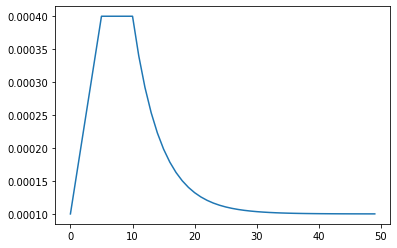

In [7]:
def lrfn(epoch=EPOCHS,
         lr_start=1e-4,
         lr_max=5e-5 * 8, 
         lr_min=1e-4,
         lr_rampup_epochs=5,
         lr_sustain_epochs=5,
         lr_exp_decay=0.8):
    if epoch < lr_rampup_epochs:
        lr = (lr_max-lr_start)/lr_rampup_epochs*epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max-lr_min)*lr_exp_decay**(epoch-lr_rampup_epochs-lr_sustain_epochs) + lr_min
    return lr

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

y = [lrfn(x) for x in range(EPOCHS)]
plt.plot(y)

In [8]:
vocab_size = len(tokenizer.word_index) + 1

with strategy.scope():
    model = Sequential()
    model.add(L.Embedding(input_dim=vocab_size,
                          output_dim=64, 
                          input_length=X_train.shape[1]))
    model.add(L.Conv1D(64, 5))
    model.add(L.GlobalMaxPooling1D())
    model.add(L.Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 64)           173710272 
_________________________________________________________________
conv1d (Conv1D)              (None, 124, 64)           20544     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 173,730,946
Trainable params: 173,730,946
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('text-cnn.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[lrs, mc], 
                 validation_data=valid_dataset, verbose=2)

Epoch 1/50


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 173710272 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 39s - loss: 0.1546 - accuracy: 0.9338 - val_loss: 0.0859 - val_accuracy: 0.9697
Epoch 2/50
902/902 - 31s - loss: 0.0199 - accuracy: 0.9937 - val_loss: 0.0893 - val_accuracy: 0.9696
Epoch 3/50
902/902 - 31s - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.0949 - val_accuracy: 0.9703
Epoch 4/50
902/902 - 31s - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0990 - val_accuracy: 0.9698
Epoch 5/50
902/902 - 30s - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.1018 - val_accuracy: 0.9697
Epoch 6/50
902/902 - 30s - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.1042 - val_accuracy: 0.9698
Epoch 7/50
902/902 - 30s - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.1059 - val_accuracy: 0.9696
Epoch 8/50
902/902 - 31s - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.1067 - val_accuracy: 0.9697
Epoch 9/50
902/902 - 31s - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.1078 - val_accuracy: 0.9696
Epoch 10/50
902/902 - 31s - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.1076 - val_accuracy: 0.9698


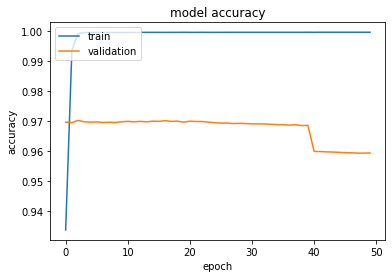

In [10]:
plot_hist(hist)

In [11]:
with strategy.scope():
    model.load_weights('text-cnn.h5')

y_prob_txt = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob_txt, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_txt[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob_txt[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 4s 9ms/step
              precision    recall  f1-score   support

           0     0.9653    0.9805    0.9728     11377
           1     0.9711    0.9490    0.9600      7870

    accuracy                         0.9676     19247
   macro avg     0.9682    0.9648    0.9664     19247
weighted avg     0.9677    0.9676    0.9676     19247

[[11155   222]
 [  401  7469]]
      TPR       FPR       FNR   ROC AUC
   0.9490    0.0195    0.0510    0.9941


In [12]:
y_prob_txt_cnn = y_prob_txt

### Text-GRU


In [13]:
vocab_size = len(tokenizer.word_index) + 1

with strategy.scope():
    model = Sequential()
    model.add(L.Embedding(input_dim=vocab_size,
                          output_dim=64, 
                          input_length=X_train.shape[1]))
    model.add(L.Bidirectional(L.GRU(64, return_sequences=True)))
    model.add(L.GlobalMaxPooling1D())
    model.add(L.Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 64)           173710272 
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 128)          49920     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 173,760,450
Trainable params: 173,760,450
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('text-gru.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[lrs, mc], 
                 validation_data=valid_dataset, verbose=2)

Epoch 1/50


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 173710272 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 45s - loss: 0.1489 - accuracy: 0.9368 - val_loss: 0.0797 - val_accuracy: 0.9707
Epoch 2/50
902/902 - 35s - loss: 0.0171 - accuracy: 0.9945 - val_loss: 0.0953 - val_accuracy: 0.9685
Epoch 3/50
902/902 - 35s - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.0995 - val_accuracy: 0.9715
Epoch 4/50
902/902 - 35s - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.1061 - val_accuracy: 0.9718
Epoch 5/50
902/902 - 35s - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.1169 - val_accuracy: 0.9713
Epoch 6/50
902/902 - 35s - loss: 0.0010 - accuracy: 0.9996 - val_loss: 0.1271 - val_accuracy: 0.9706
Epoch 7/50
902/902 - 35s - loss: 9.7472e-04 - accuracy: 0.9996 - val_loss: 0.1273 - val_accuracy: 0.9702
Epoch 8/50
902/902 - 35s - loss: 9.3837e-04 - accuracy: 0.9996 - val_loss: 0.1397 - val_accuracy: 0.9694
Epoch 9/50
902/902 - 35s - loss: 9.1352e-04 - accuracy: 0.9996 - val_loss: 0.1479 - val_accuracy: 0.9694
Epoch 10/50
902/902 - 35s - loss: 8.9770e-04 - accuracy: 0.9996 - val_loss: 0.1564 - val_a

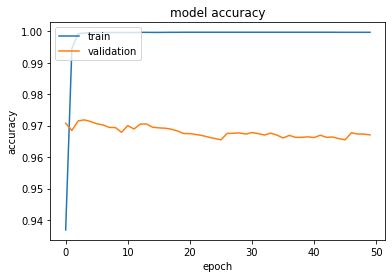

In [15]:
plot_hist(hist)

In [16]:
with strategy.scope():
    model.load_weights('text-gru.h5')

y_prob_txt = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob_txt, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_txt[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob_txt[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 5s 12ms/step
              precision    recall  f1-score   support

           0     0.9638    0.9819    0.9728     11377
           1     0.9731    0.9468    0.9597      7870

    accuracy                         0.9675     19247
   macro avg     0.9685    0.9643    0.9663     19247
weighted avg     0.9676    0.9675    0.9675     19247

[[11171   206]
 [  419  7451]]
      TPR       FPR       FNR   ROC AUC
   0.9468    0.0181    0.0532    0.9946


In [17]:
y_prob_txt_gru = y_prob_txt

### Bidirectional LSTM


In [18]:
vocab_size = len(tokenizer.word_index) + 1

with strategy.scope():
    model = Sequential()
    model.add(L.Embedding(input_dim=vocab_size,
                          output_dim=64, 
                          input_length=X_train.shape[1]))
    model.add(L.Bidirectional(L.LSTM(64, return_sequences=True)))
    model.add(L.GlobalMaxPooling1D())
    model.add(L.Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 128, 64)           173710272 
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128, 128)          66048     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 173,776,578
Trainable params: 173,776,578
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('text-lstm.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[lrs, mc], 
                 validation_data=valid_dataset, verbose=2)

Epoch 1/50


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 173710272 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 45s - loss: 0.1587 - accuracy: 0.9317 - val_loss: 0.0821 - val_accuracy: 0.9705
Epoch 2/50
902/902 - 34s - loss: 0.0241 - accuracy: 0.9921 - val_loss: 0.0956 - val_accuracy: 0.9678
Epoch 3/50
902/902 - 34s - loss: 0.0048 - accuracy: 0.9988 - val_loss: 0.1113 - val_accuracy: 0.9696
Epoch 4/50
902/902 - 34s - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.1200 - val_accuracy: 0.9685
Epoch 5/50
902/902 - 34s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.1285 - val_accuracy: 0.9682
Epoch 6/50
902/902 - 34s - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.1341 - val_accuracy: 0.9686
Epoch 7/50
902/902 - 35s - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.1405 - val_accuracy: 0.9691
Epoch 8/50
902/902 - 34s - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.1521 - val_accuracy: 0.9684
Epoch 9/50
902/902 - 34s - loss: 0.0010 - accuracy: 0.9996 - val_loss: 0.1445 - val_accuracy: 0.9688
Epoch 10/50
902/902 - 34s - loss: 9.7246e-04 - accuracy: 0.9996 - val_loss: 0.1617 - val_accuracy: 0.9

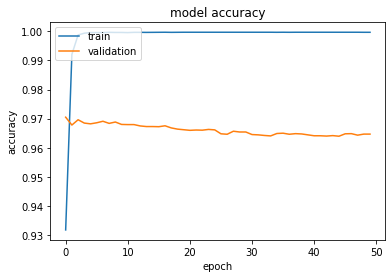

In [20]:
plot_hist(hist)

In [21]:
with strategy.scope():
    model.load_weights('text-lstm.h5')

y_prob_txt = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob_txt, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_txt[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob_txt[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 7s 12ms/step
              precision    recall  f1-score   support

           0     0.9621    0.9837    0.9728     11377
           1     0.9757    0.9440    0.9596      7870

    accuracy                         0.9675     19247
   macro avg     0.9689    0.9639    0.9662     19247
weighted avg     0.9677    0.9675    0.9674     19247

[[11192   185]
 [  441  7429]]
      TPR       FPR       FNR   ROC AUC
   0.9440    0.0163    0.0560    0.9944


In [22]:
y_prob_txt_lstm = y_prob_txt

# Fusion with Image-based Detection

In [23]:
def prepare_data(name):
    if glob(dataset_path + f'image/defaced/{name}.png'):
        return (f'{GCS_DS_PATH}/image/defaced/{name}.png', 1)
    else:
        return (f'{GCS_DS_PATH}/image/benign/{name}.png', 0)

output = Parallel(n_jobs=N_JOBS)(delayed(prepare_data)(name) for name in tqdm(names))
X, y = zip(*output)

X_train, X_test, y_train, y_test_ = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, 
                                                      random_state=42)

print(len(X_train), len(X_valid), len(X_test))
print((y_test == y_test_).all())

  0%|          | 0/96234 [00:00<?, ?it/s]

57740 19247 19247
True


In [24]:
def decode_image(filename, label=None):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_png(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    if label is None:
        return image
    else:
        return image, label

test_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices(X_test)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

## ViTB32


In [25]:
!pip install --quiet vit-keras

from vit_keras import vit

In [26]:
!pip install -q efficientnet
from efficientnet.tfkeras import EfficientNetB0

with strategy.scope():
    net = vit.vit_b32(
        image_size = (IMG_SIZE, IMG_SIZE),
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False
    )
    model = Sequential()
    model.add(net)
    model.add(L.BatchNormalization())
    model.add(L.Dense(128, activation='softmax'))
    model.add(L.BatchNormalization())
    model.add(L.Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.load_weights('../input/deface-vitb32/weights.h5')

353255424/353253686 [==============================] - 5s 0us/step


/opt/conda/lib/python3.7/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


In [27]:
y_prob_img = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob_img, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_img[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob_img[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 655s 2s/step
              precision    recall  f1-score   support

           0     0.8919    0.9296    0.9104     11377
           1     0.8916    0.8371    0.8635      7870

    accuracy                         0.8918     19247
   macro avg     0.8917    0.8833    0.8869     19247
weighted avg     0.8918    0.8918    0.8912     19247

[[10576   801]
 [ 1282  6588]]
      TPR       FPR       FNR   ROC AUC
   0.8371    0.0704    0.1629    0.9546


### Fusion

**Text_CNN**

In [28]:
y_prob = (y_prob_img + y_prob_txt_cnn) / 2
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

              precision    recall  f1-score   support

           0     0.9740    0.9783    0.9761     11377
           1     0.9684    0.9623    0.9653      7870

    accuracy                         0.9717     19247
   macro avg     0.9712    0.9703    0.9707     19247
weighted avg     0.9717    0.9717    0.9717     19247

[[11130   247]
 [  297  7573]]
      TPR       FPR       FNR   ROC AUC
   0.9623    0.0217    0.0377    0.9943


**Text_GRU**

In [29]:
y_prob = (y_prob_img + y_prob_txt_gru) / 2
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

              precision    recall  f1-score   support

           0     0.9722    0.9812    0.9767     11377
           1     0.9724    0.9595    0.9659      7870

    accuracy                         0.9723     19247
   macro avg     0.9723    0.9703    0.9713     19247
weighted avg     0.9723    0.9723    0.9723     19247

[[11163   214]
 [  319  7551]]
      TPR       FPR       FNR   ROC AUC
   0.9595    0.0188    0.0405    0.9945


**Text_LSTM**

In [30]:
y_prob = (y_prob_img + y_prob_txt_lstm) / 2
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

              precision    recall  f1-score   support

           0     0.9718    0.9808    0.9762     11377
           1     0.9718    0.9588    0.9653      7870

    accuracy                         0.9718     19247
   macro avg     0.9718    0.9698    0.9708     19247
weighted avg     0.9718    0.9718    0.9718     19247

[[11158   219]
 [  324  7546]]
      TPR       FPR       FNR   ROC AUC
   0.9588    0.0192    0.0412    0.9944


## VGG19

In [31]:
from tensorflow.keras.applications import VGG19

with strategy.scope():
    net = VGG19(
        include_top=False, 
        weights='imagenet', 
        pooling='avg', 
        input_shape=(IMG_SIZE, IMG_SIZE, 3))

    model = Sequential()
    model.add(net)
    model.add(L.BatchNormalization())
    model.add(L.Dense(128, activation='softmax'))
    model.add(L.BatchNormalization())
    model.add(L.Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.load_weights('../input/deface-vgg19/weights.h5')

80142336/80134624 [==============================] - 1s 0us/step


In [32]:
y_prob_img = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob_img, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_img[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob_img[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 478s 2s/step
              precision    recall  f1-score   support

           0     0.7821    0.8380    0.8091     11377
           1     0.7388    0.6625    0.6986      7870

    accuracy                         0.7662     19247
   macro avg     0.7605    0.7503    0.7538     19247
weighted avg     0.7644    0.7662    0.7639     19247

[[9534 1843]
 [2656 5214]]
      TPR       FPR       FNR   ROC AUC
   0.6625    0.1620    0.3375    0.8099


### Fusion

**Text_CNN**

In [33]:
y_prob = (y_prob_img + y_prob_txt_cnn) / 2
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

              precision    recall  f1-score   support

           0     0.9650    0.9829    0.9739     11377
           1     0.9747    0.9484    0.9614      7870

    accuracy                         0.9688     19247
   macro avg     0.9698    0.9657    0.9676     19247
weighted avg     0.9689    0.9688    0.9688     19247

[[11183   194]
 [  406  7464]]
      TPR       FPR       FNR   ROC AUC
   0.9484    0.0171    0.0516    0.9881


**Text_GRU**

In [34]:
y_prob = (y_prob_img + y_prob_txt_gru) / 2
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

              precision    recall  f1-score   support

           0     0.9646    0.9861    0.9752     11377
           1     0.9793    0.9476    0.9632      7870

    accuracy                         0.9704     19247
   macro avg     0.9719    0.9669    0.9692     19247
weighted avg     0.9706    0.9704    0.9703     19247

[[11219   158]
 [  412  7458]]
      TPR       FPR       FNR   ROC AUC
   0.9476    0.0139    0.0524    0.9884


**Text_LSTM**

In [35]:
y_prob = (y_prob_img + y_prob_txt_lstm) / 2
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

              precision    recall  f1-score   support

           0     0.9648    0.9861    0.9754     11377
           1     0.9793    0.9480    0.9634      7870

    accuracy                         0.9705     19247
   macro avg     0.9720    0.9671    0.9694     19247
weighted avg     0.9707    0.9705    0.9705     19247

[[11219   158]
 [  409  7461]]
      TPR       FPR       FNR   ROC AUC
   0.9480    0.0139    0.0520    0.9886


## DenseNet169

In [36]:
from tensorflow.keras.applications import DenseNet169

with strategy.scope():
    net = DenseNet169(
        include_top=False, 
        weights='imagenet', 
        pooling='avg', 
        input_shape=(IMG_SIZE, IMG_SIZE, 3))

    model = Sequential()
    model.add(net)
    model.add(L.BatchNormalization())
    model.add(L.Dense(128, activation='softmax'))
    model.add(L.BatchNormalization())
    model.add(L.Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.load_weights('../input/deface-densenet169/weights.h5')

51879936/51877672 [==============================] - 0s 0us/step


In [37]:
y_prob_img = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob_img, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_img[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob_img[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 492s 2s/step
              precision    recall  f1-score   support

           0     0.8663    0.9600    0.9107     11377
           1     0.9315    0.7858    0.8524      7870

    accuracy                         0.8888     19247
   macro avg     0.8989    0.8729    0.8816     19247
weighted avg     0.8929    0.8888    0.8869     19247

[[10922   455]
 [ 1686  6184]]
      TPR       FPR       FNR   ROC AUC
   0.7858    0.0400    0.2142    0.9596


### Fusion

**Text_CNN**

In [38]:
y_prob = (y_prob_img + y_prob_txt_cnn) / 2
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

              precision    recall  f1-score   support

           0     0.9650    0.9867    0.9757     11377
           1     0.9802    0.9483    0.9640      7870

    accuracy                         0.9710     19247
   macro avg     0.9726    0.9675    0.9699     19247
weighted avg     0.9712    0.9710    0.9709     19247

[[11226   151]
 [  407  7463]]
      TPR       FPR       FNR   ROC AUC
   0.9483    0.0133    0.0517    0.9946


**Text_GRU**

In [39]:
y_prob = (y_prob_img + y_prob_txt_gru) / 2
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

              precision    recall  f1-score   support

           0     0.9641    0.9890    0.9764     11377
           1     0.9835    0.9468    0.9648      7870

    accuracy                         0.9717     19247
   macro avg     0.9738    0.9679    0.9706     19247
weighted avg     0.9720    0.9717    0.9716     19247

[[11252   125]
 [  419  7451]]
      TPR       FPR       FNR   ROC AUC
   0.9468    0.0110    0.0532    0.9948


**Text_LSTM**

In [40]:
y_prob = (y_prob_img + y_prob_txt_lstm) / 2
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

              precision    recall  f1-score   support

           0     0.9631    0.9882    0.9755     11377
           1     0.9823    0.9452    0.9634      7870

    accuracy                         0.9706     19247
   macro avg     0.9727    0.9667    0.9695     19247
weighted avg     0.9709    0.9706    0.9706     19247

[[11243   134]
 [  431  7439]]
      TPR       FPR       FNR   ROC AUC
   0.9452    0.0118    0.0548    0.9948
